Transcribing with both models: 100%|███████████████████████████████████████████████████| 39/39 [07:01<00:00, 10.81s/it]


Comparison saved to comparisonBaseModelDatasetA.csv

Baseline Whisper Avg Accuracy: 66.78%
Fine-Tuned Whisper Avg Accuracy: 74.56%


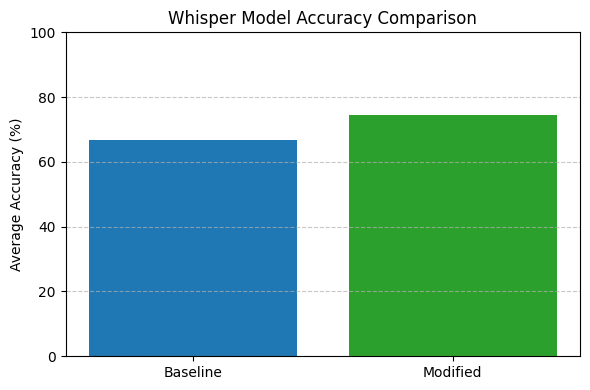

In [12]:
#comparing the whisper base model with finetune whisper base model on dataset a

import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from pydub import AudioSegment
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import matplotlib.pyplot as plt

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

supported_formats = (".mp3", ".wav")  # Add other formats if needed

# 1. Load model from checkpoint
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
# 2. Load processor/tokenizer from original pretrained model (e.g., "openai/whisper-base.en")
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()


def custom_transcribe(audio_path):
    # Load and preprocess the audio
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    # Extract features
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    # 🔥 Remove forced_decoder_ids from model config directly
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    # Generate and decode
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)

    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription


def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        # Load ground truth
        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100,0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100,0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetA_.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

# Run transcription on the audio datasets
audio_dir = "dataset/a/"  
baseline_results, modified_results = transcribe_with_both_models(audio_dir)

# Save to CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetA_.csv")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()


Transcribing with both models: 100%|███████████████████████████████████████████████████| 51/51 [08:40<00:00, 10.21s/it]


Comparison saved to comparisonBaseModelDatasetB_.csv

Baseline Whisper Avg Accuracy: 51.39%
Fine-Tuned Whisper Avg Accuracy: 64.43%


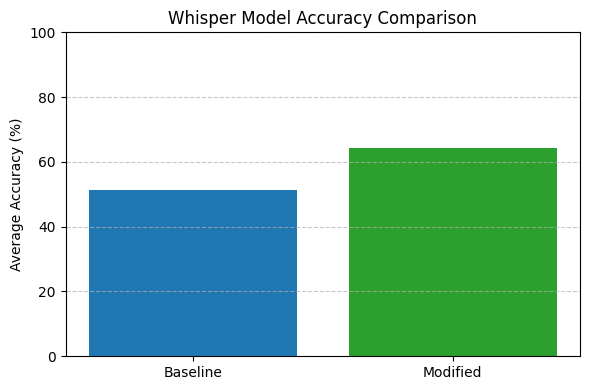

In [14]:
#comparing the whisper base model with finetune whisper base model on dataset b

import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from pydub import AudioSegment
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import matplotlib.pyplot as plt

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

supported_formats = (".mp3", ".wav")  # Add other formats if needed

# 1. Load model from checkpoint
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
# 2. Load processor/tokenizer from original pretrained model (e.g., "openai/whisper-base.en")
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()


def custom_transcribe(audio_path):
    # Load and preprocess the audio
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    # Extract features
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    # 🔥 Remove forced_decoder_ids from model config directly
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    # 6. Generate tokens
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)
    
    # 7. Decode transcription
    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription


def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        # Load ground truth
        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100,0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100,0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetB_.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

# Run transcription on the audio datasets
audio_dir = "dataset/b/"  
baseline_results, modified_results = transcribe_with_both_models(audio_dir)

# Save to CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetB_.csv")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()


Transcribing with both models: 100%|███████████████████████████████████████████████████| 32/32 [06:44<00:00, 12.64s/it]


Comparison saved to comparisonBaseModelDatasetC.csv

Baseline Whisper Avg Accuracy: 39.97%
Fine-Tuned Whisper Avg Accuracy: 62.59%


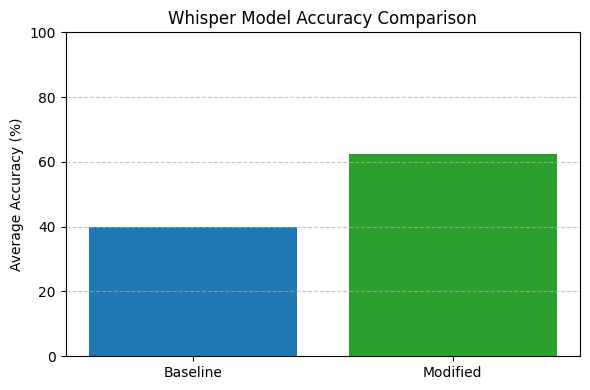

In [13]:
#comparing the whisper base model with finetune whisper base model on dataset c

import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from pydub import AudioSegment
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import matplotlib.pyplot as plt

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

supported_formats = (".mp3", ".wav")  # Add other formats if needed

# 1. Load model from checkpoint
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
# 2. Load processor/tokenizer from original pretrained model (e.g., "openai/whisper-base.en")
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()


def custom_transcribe(audio_path):
    # Load and preprocess the audio
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    # Extract features
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    # 🔥 Remove forced_decoder_ids from model config directly
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    # 6. Generate tokens
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)
    
    # 7. Decode transcription
    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription


def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        # Load ground truth
        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100,0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100,0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetC.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

# Run transcription on the audio datasets
audio_dir = "dataset/c/"  
baseline_results, modified_results = transcribe_with_both_models(audio_dir)

# Save to CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetC.csv")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()


Transcribing with both models: 100%|███████████████████████████████████████████████████| 66/66 [09:32<00:00,  8.68s/it]


Comparison saved to comparisonBaseModelDatasetD.csv

Baseline Whisper Avg Accuracy: 71.93%
Fine-Tuned Whisper Avg Accuracy: 78.56%


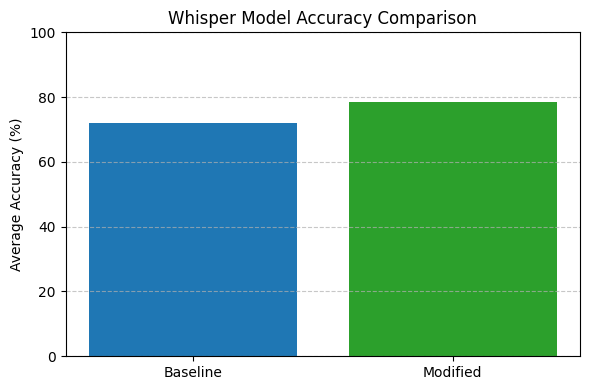

In [15]:
#comparing the whisper base model with finetune whisper base model on dataset d

import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from pydub import AudioSegment
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import matplotlib.pyplot as plt

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

supported_formats = (".mp3", ".wav")  # Add other formats if needed

# 1. Load model from checkpoint
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
# 2. Load processor/tokenizer from original pretrained model (e.g., "openai/whisper-base.en")
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()


def custom_transcribe(audio_path):
    # Load and preprocess the audio
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    # Extract features
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    # 🔥 Remove forced_decoder_ids from model config directly
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None

    # 6. Generate tokens
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)
    
    # 7. Decode transcription
    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription


def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        # Load ground truth
        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline Whisper transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]
        base_error = jiwer.wer(ground_truth, base_text, truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100,0)

        # Fine-tuned Whisper transcription
        try:
            modified_text = custom_transcribe(file_path)
            mod_error = jiwer.wer(ground_truth, modified_text, truth_transform=transforms, hypothesis_transform=transforms)
            mod_accuracy = max((1 - mod_error) * 100,0)
        except Exception as e:
            modified_text = ""
            mod_accuracy = 0.0
            print(f"Error processing {filename} with fine-tuned model: {e}")

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetD.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

# Run transcription on the audio datasets
audio_dir = "dataset/d/"  
baseline_results, modified_results = transcribe_with_both_models(audio_dir)

# Save to CSV
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetD.csv")

# Print average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)
print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

# Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()
